In [3]:
import pandas as pd
titanic = pd.read_csv('train.csv')
titanic_test = pd.read_csv('test.csv')

def clean_data(data, age_filler):
    data.Age = data.Age.fillna(age_filler)
    data.Fare = data.Fare.fillna(data.Fare.median())
    data.loc[data.Sex == "female", "Sex"] = 1
    data.loc[data.Sex == "male", "Sex"] = 0
    data.Embarked = data.Embarked.fillna("S")
    data.loc[data.Embarked == "S", "Embarked"] = 0
    data.loc[data.Embarked == "C", "Embarked"] = 1
    data.loc[data.Embarked == "Q", "Embarked"] = 2
    return data
    
titanic = clean_data(titanic, titanic.Age.median())
titanic_test = clean_data(titanic_test, titanic.Age.median())
print "cleaned"

cleaned


In [4]:
def parse_port(port):
    if port == 0: # port is s=0, c=1, q=2
        return 1,0,0
    elif port == 1:
        return 0,1,0
    elif port == 2:
        return 0,0,1

def make_embarked_cols(data):
    s = []
    c = []
    q = []

    for port in data.Embarked:
        sbool, cbool, qbool = parse_port(port)
        s.append(sbool)
        c.append(cbool)
        q.append(qbool)

    data['EmbarkedS'] = s
    data['EmbarkedC'] = c
    data['EmbarkedQ'] = q
    
    return data

make_embarked_cols(titanic)
make_embarked_cols(titanic_test)

titanic['Child'] = titanic.Age <= 8
titanic_test['Child'] = titanic_test.Age <= 8

This code was copied from model_iteration_1 and just allows us to import and clean the data the same way I did in the first iteration.  It also uses my code from my model improvements to add the extra columns I created

In [5]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "EmbarkedS", "EmbarkedQ", "EmbarkedC", "Child"]

alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

0.793490460157


In [6]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

0.830527497194


These are solely based on the DataQuest suggestions of parameters to tune.  It says that the number of trees will improve your model "up to a point" - I wonder where that is?

In [9]:
fitscores = []
for i in range(1,500):
    alg = RandomForestClassifier(random_state=1, n_estimators=i, min_samples_split=4, min_samples_leaf=2)
    fitscores.append(cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3))


AttributeError: 'module' object has no attribute 'plot'

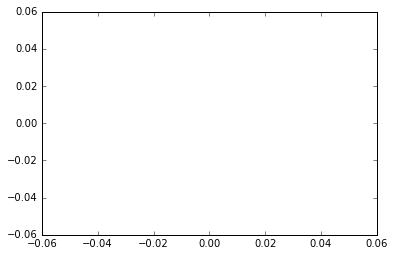

In [8]:
for i in range(len(fitscores)):
    fitscores[i] = fitscores[i].mean()
#print fitscores

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(fitscores)
plt.show()

I learned a couple things from this (besides that it took a loooong time to run, maybe should have skipped every 10 values or so) is that a) I should have made more algorithms at each tree number so it would be less noisy, and b) once you have sufficient number of trees in your forest (here, seems like 50, maybe), adding more doesn't really help too much.  Let's do another one for mins?

[0.79910213243546568, 0.79910213243546568, 0.79910213243546568, 0.79910213243546568, 0.79910213243546568, 0.79910213243546568, 0.79910213243546568, 0.79910213243546568, 0.79910213243546568, 0.79910213243546568]
[0.83164983164983164, 0.83164983164983164, 0.83164983164983164, 0.83164983164983164, 0.83164983164983164, 0.83164983164983164, 0.83164983164983164, 0.83164983164983164, 0.83164983164983164, 0.83164983164983164]
[0.82379349046015715, 0.82379349046015715, 0.82379349046015715, 0.82379349046015715, 0.82379349046015715, 0.82379349046015715, 0.82379349046015715, 0.82379349046015715, 0.82379349046015715, 0.82379349046015715]
[0.81705948372615034, 0.81705948372615034, 0.81705948372615034, 0.81705948372615034, 0.81705948372615034, 0.81705948372615034, 0.81705948372615034, 0.81705948372615034, 0.81705948372615034, 0.81705948372615034]
[0.82154882154882147, 0.82154882154882147, 0.82154882154882147, 0.82154882154882147, 0.82154882154882147, 0.82154882154882147, 0.82154882154882147, 0.821548

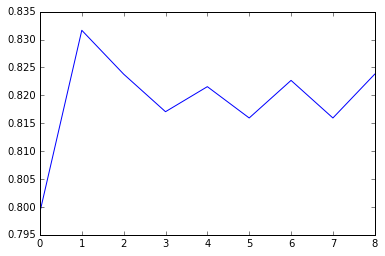

In [18]:
fitscores_min = []
for i in range(2,20,2):
    means = []
    for j in range(10): # average of 10 tries
        alg = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=i, min_samples_leaf=i/2)
        means.append(cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3).mean())
    fitscores_min.append(sum(means)/len(means))
    print means # print progress
plt.plot(fitscores_min)
plt.show()

The values on the bottom are actually 2,4,6,8...18, and it looks like the highest-scoring values are 4 for min split and 2 for min leaf.  Based on these results, I'll go head and use 100 trees and 4/2 for the mins for my model.

In [9]:
# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print(pd.value_counts(titles))

# Add in the title column.
titanic["Title"] = titles

import operator

# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique id.
print(pd.value_counts(family_ids))

titanic["FamilyId"] = family_ids

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64
-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


This is from the DataQuest example - some new columns to improve the model.  This code adds a column for family size, for title, and for which family you come from

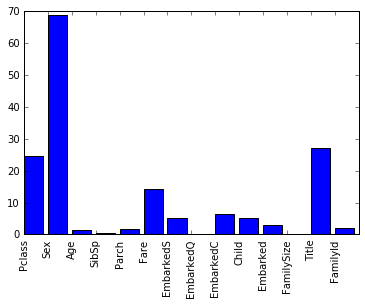

In [10]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

import matplotlib.pyplot as plt
%matplotlib inline

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "EmbarkedS", "EmbarkedQ", "EmbarkedC", "Child", "Embarked", "FamilySize", "Title", "FamilyId"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

From this we can see which factors are most important.  I'm really surprised to see Age/Child both low-ranked, based on what I learned from my explorations.  I'm going to select the most important factors based on this: (PClass, Sex, Fare, Title), but also include Child because we know it's important.

In [11]:
# Pick only the best features.
predictors = ["Pclass", "Sex", "Fare", "Title", "Child"]

alg = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=4, min_samples_leaf=2)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

0.804713804714


In [12]:
from sklearn.ensemble import GradientBoostingClassifier

predictors_gradboost = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "EmbarkedS", "EmbarkedQ", "EmbarkedC", "Child", "Embarked", "FamilySize", "Title", "FamilyId"]

alg = GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3)

scores = cross_validation.cross_val_score(alg, titanic[predictors_gradboost], titanic["Survived"], cv=3)
print(scores.mean())


0.818181818182


In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
import numpy as np

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)


0.819304152637


/home/anne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [14]:
# First, we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title.
print(pd.value_counts(titanic_test["Title"]))

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# Now we can add family ids.
# We'll use the same ids that we did earlier.
print(family_id_mapping)

family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids

titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))


algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors_gradboost],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "EmbarkedS", "EmbarkedC", "EmbarkedQ", "Child"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4

predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1
predictions = predictions.astype(int) 

submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

print submission

submission.to_csv("model2_1.csv", index=False)

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64
{"O'Sullivan0": 426, 'Mangan0': 620, 'Lindqvist1': 543, 'Denkoff0': 297, 'Rouse0': 413, 'Berglund0': 207, 'Meo0': 142, 'Arnold-Franchi1': 49, 'Chronopoulos1': 71, 'Skoog5': 63, 'Widener2': 329, 'Pengelly0': 217, 'Goncalves0': 400, 'Myhrman0': 626, 'Beane1': 456, 'Moss0': 104, 'Carlsson0': 610, 'Nicholls2': 136, 'Jussila1': 110, 'Jussila0': 483, 'Long0': 632, 'Wheadon0': 33, 'Connolly0': 261, 'Hansen2': 680, 'Stephenson1': 493, 'Davies0': 336, 'Silven2': 359, 'Vanden Steen0': 311, 'Astor1': 571, 'Patchett0': 480, 'Johanson0': 184, 'Coleridge0': 220, 'Christmann0': 87, 'Carter3': 340, 'Compton2': 665, 'Carter1': 226, 'Turkula0': 414, 'Hassab0': 558, 'Saad0': 566, 'Mellors0': 208, 'Mamee0': 36, 'Madsen0': 119, 'Anderson0': 395, 'Kraeff0': 42, 'Robbins0': 468, 'Lundahl0': 522, 'Gilinski0': 490, 'Porter0': 107, 'Sdycoff0': 352, 'Green0': 204, 'Bishop1': 263, 'Sinkkonen0': 603, 'Otter0':

Using the code from DataQuest, I earned a 0.78947 

Now, I want to try to tweak some of these models to get a better score.  What I just submitted was an ensemble of the logistic regression and the gradient boost - I wonder what will happen if I make an ensemble of the random forest and the gradient boost - or of all 3

In [15]:
def do_ensemble(algorithms):

    # Initialize the cross validation folds
    kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

    predictions = []
    for train, test in kf:
        train_target = titanic["Survived"].iloc[train]
        full_test_predictions = []
        # Make predictions for each algorithm on each fold
        for alg, predictors in algorithms:
            # Fit the algorithm on the training data.
            alg.fit(titanic[predictors].iloc[train,:], train_target)
            # Select and predict on the test fold.  
            # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
            test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
            full_test_predictions.append(test_predictions)
        # Use a simple ensembling scheme -- just average the predictions to get the final classification.
        test_predictions = sum(full_test_predictions) / len(full_test_predictions)
        # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
        test_predictions[test_predictions <= .5] = 0
        test_predictions[test_predictions > .5] = 1
        predictions.append(test_predictions)

    # Put all the predictions together into one array.
    predictions = np.concatenate(predictions, axis=0)

    # Compute accuracy by comparing to the training data.
    accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
    return accuracy


# for simplicity sake, I'm going to start by using the predictors_gradboost list, which has pretty much every column of note
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors_gradboost],
    [RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=4, min_samples_leaf=2), predictors_gradboost]
]
algorithms2 = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors_gradboost],
    [RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=4, min_samples_leaf=2), predictors_gradboost],
    [LogisticRegression(random_state=1), predictors_gradboost]
]
algorithms3 = [
    [RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=4, min_samples_leaf=2), predictors_gradboost],
    [LogisticRegression(random_state=1), predictors_gradboost]
]
algorithms4 = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors_gradboost],
    [LogisticRegression(random_state=1), predictors_gradboost]
]
algorithms5 = [[GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors_gradboost]]
algorithms6 = [[GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors_gradboost],
              [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors_gradboost]]

print do_ensemble(algorithms)
print do_ensemble(algorithms2)
print do_ensemble(algorithms3)
print do_ensemble(algorithms4)
print do_ensemble(algorithms5)
print do_ensemble(algorithms6) # 5 and 6 should be the same

0.830527497194
0.818181818182
0.81593714927
0.817059483726
0.820426487093
0.820426487093


/home/anne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


I was really surprised that the all-three did more poorly than Grad+RF, so I went ahead and calculated all the pairs.  And it turns out, all the ones that do kind of poorly are the logistic regression ones.  Is it because of logistic regression, or because I'm doing bad regression because of all the columns I'm giving it?

I'm going to try to do this procedurally.  I have three models I can use: LR, GB, and RF.  I already determined the "ideal" parameters for RF so I'll just hold those constant for simplicity's sake.  But I can go ahead and make a bunch of models based on which parameter lists I give them, and then make combinations of these models.


In [22]:
lr = LogisticRegression(random_state=1)
gb = GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3)
rf = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=4, min_samples_leaf=2)

all_p = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "EmbarkedS", "EmbarkedQ", "EmbarkedC", "Child", "Embarked", "FamilySize", "Title", "FamilyId"]
best_p = ["Pclass", "Sex", "Fare", "Title", "Child"]

algs = [lr, gb, rf]
ps = [all_p, best_p]

maxscore = 0
maxalgs = ""
maxps = ""

#trios
for alg1 in algs:
    for alg2 in algs:
        for alg3 in algs:
            for p1 in ps:
                for p2 in ps:
                    for p3 in ps:
                        score = do_ensemble([[alg1, p1], [alg2, p1], [alg3, p2]])
                        print score
                        if score > maxscore:
                            maxscore = score
                            maxalgs = str(type(alg1)) + str(type(alg2)) + str(type(alg3))
                            maxps = str(len(p1)) + str(len(p2))

0.803591470258
0.803591470258
0.79797979798
0.79797979798
0.801346801347
0.801346801347
0.79012345679
0.79012345679
0.808080808081
0.808080808081
0.806958473625
0.806958473625
0.809203142536
0.809203142536
0.812570145903
0.812570145903
0.808080808081
0.808080808081
0.806958473625
0.806958473625
0.806958473625
0.806958473625
0.813692480359
0.813692480359
0.808080808081
0.808080808081
0.806958473625
0.806958473625
0.806958473625
0.806958473625
0.812570145903
0.812570145903
0.819304152637
0.819304152637
0.822671156004
0.822671156004
0.822671156004
0.822671156004
0.818181818182
0.818181818182
0.818181818182
0.818181818182
0.82379349046
0.82379349046
0.818181818182
0.818181818182
0.814814814815
0.814814814815
0.808080808081
0.808080808081
0.811447811448
0.811447811448
0.803591470258
0.803591470258
0.813692480359
0.813692480359
0.818181818182
0.818181818182
0.818181818182
0.818181818182
0.817059483726
0.817059483726
0.814814814815
0.814814814815
0.818181818182
0.818181818182
0.821548821549
0

/home/anne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


Side note: I am super super aware that this was a horribly inefficient way to figure this out.  It had a ton of repeats and extra unnecessary calculations.  What would be a better way to figure out this information than all these awful nested for loops?  And I was also trying to think of a good way to visually convey this information, but nothing good was coming to mind.  It's just some combination of 3 different variables (so, 7 different order possibilities - we have all 3, 3 different pairs, or 3 single-variable), and for each variable in those it can go one of two ways for the predictors.  It probably just feels more complicated than it is, but if I had more time to really work hard on this kind of extraneous component, I'd like to figure out a good way to represent this

In [41]:
print maxscore
print maxalgs
print maxps

0.837261503928
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'><class 'sklearn.ensemble.forest.RandomForestClassifier'><class 'sklearn.ensemble.forest.RandomForestClassifier'>
1414


A little disappointed that it told me the best combination was the one that I had already tried: RF + GB, using all the variables.  But I'm going to go ahead and submit to Kaggle to see what it says:

In [48]:
def make_submission(algorithms, filename): 

    full_predictions = []
    for alg, predictors in algorithms:
        # Fit the algorithm using the full training data.
        alg.fit(titanic[predictors], titanic["Survived"])
        # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
        predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
        full_predictions.append(predictions)

    # The gradient boosting classifier generates better predictions, so we weight it higher.
    #predictions = (full_predictions[1] * 3 + full_predictions[0]) / 4

    predictions[predictions <= 0.5] = 0
    predictions[predictions > 0.5] = 1
    predictions = predictions.astype(int) 

    submission = pd.DataFrame({
            "PassengerId": titanic_test["PassengerId"],
            "Survived": predictions
        })

    submission.to_csv(filename, index=False)
    
lr = LogisticRegression(random_state=1)
gb = GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3)
rf = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=4, min_samples_leaf=2)
    
algorithms = [
    [gb, all_p],
    [rf, all_p]
]
make_submission(algorithms, "model2_2.csv")

So, I was really surprised to find that it was _not_ an improvement on my previous submission.  My first submission for iteration 2, which was GB + LR and used all_p for GB, most of the predictors for LR.  This one (RF + GB, all_p) scored 0.78469, which is slightly worse, even though it did significantly better (2%!) in the cross-validation kfold testing on my training data.

Then, I realized I had left in the weighting from my original submission that weighted the first algorithm (in this case, GB) higher - so I commented that out was surpised that my score went down to 0.77033

Okay, how do the variables of GB change it?  Let's find out!

/home/anne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


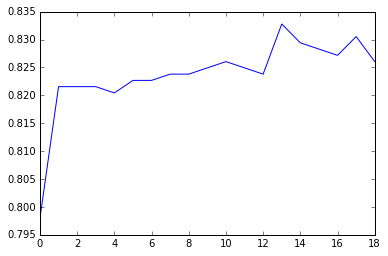

In [29]:
nestim = []

for i in range(5,100,5):
    tests = []
    for j in range(10):     
        gb = [[GradientBoostingClassifier(random_state=1, n_estimators=i, max_depth=3), predictors_gradboost]]
        tests.append(do_ensemble(gb))
    nestim.append(sum(tests)/len(tests))

plt.plot(nestim)
plt.show()

Since we went by 5s, we can multiply each x-axis value by 5 to get the best n_estimators.  It looks like 13 is best, which is 65 estimators.  We can try that.

/home/anne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


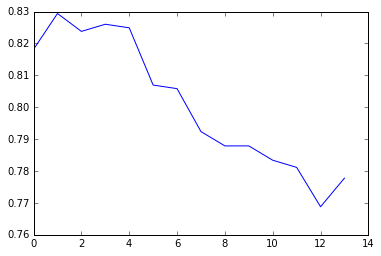

In [31]:
maxdepth = []

for i in range(1,15):
    tests = []
    for j in range(10):     
        gb = [[GradientBoostingClassifier(random_state=1, n_estimators=65, max_depth=i), predictors_gradboost]]
        tests.append(do_ensemble(gb))
    maxdepth.append(sum(tests)/len(tests))

plt.plot(maxdepth)
plt.show()

This is really interesting - I wasn't expecting the accuracy to go down with increased max_depth.  So based on this, I'm going to use a max_depth 2 because it's actually slightly higher than the 3 we were using before

Another thought of something to try: we know that gradient boosting and RF seem to be working better that logistic regression.  What if I made an ensemble of a lot of different RF/GB combos with different parameters?

In [38]:
algs = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), all_p],
    [GradientBoostingClassifier(random_state=1, n_estimators=65, max_depth=2), all_p],
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), best_p],
    [GradientBoostingClassifier(random_state=1, n_estimators=65, max_depth=2), best_p],
    [RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=4, min_samples_leaf=2), all_p],
    [RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=4, min_samples_leaf=2), best_p]
]
print do_ensemble(algs)

0.824915824916


/home/anne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


It went down from the single GB/RF combo :( so it seems that adding more variety to my ensemble doesn't actually help it.  Regardless, let's try it out on the test data

In [39]:
make_submission(algs, "model2_3.csv")

It scored .78469 - still not an improvement on my original submission (the one that DataQuest helped with, the one with logistic regression in the ensemble instead of RF, and the one that did more poorly on my cross-validation)

Okay, one more thing to try.  Since I guess my original LR/GB combo is best, let's try it again but with the newly determined "best" GB parameters?

In [53]:
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=65, max_depth=2), all_p],
    [LogisticRegression(random_state=1), all_p]
]

print do_ensemble(algorithms)
make_submission(algorithms, "model2_4.csv")

0.817059483726


/home/anne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


Disappointingly, still not better!  It got 0.77512.  It predicted 77% of the test data correctly.

At this point, I have no submissions left for today.  I'm a little disappointed because a lot of the things I tried, I was pretty convinced my optimizations had worked and that it would score higher.  I wonder if the high-scoring cross-validations that got lower scores on the test data did so because they were overfitting?  If that's the case, how can I possibly come up with the best model, if a too-high score means it will score lower on the test data?

At least, I feel like I learned from this.  The gradient boost algorithm is still a little fuzzy for me, but I think DataQuest did a really good job explaining what was going on behind the scenes of the random forest, and I really liked that.

Ideas for future iterations, I think, would be to learn more algorithms and try them all out.  I feel a little bit like I beat the algorithms over and over (try GB + RF! Optimize GB!  Optimize RF!  Optimize with different predictors of lists! Optimize with different ensemble combinations! etc) and even though some were slightly better/worse than the others, it never varied by more than like 2%, and if I really want to improve this model, I'd need to take a new approach that we haven't learned yet.  I looked through a bunch of other Python scripts and models from the Kaggle collection, and found that most of them were using random forests, so I'm not sure what other models are out there to help get a better score.